- Extended figure 16

# 1. Pseudobulk & Correlation Analysis
- Extended figure 16

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad

import mplscience
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.utils import check_random_state
from sklearn.metrics import pairwise_distances
# from mousipy import translate

data_path = '../public/'
marker_path = '../markers/'
plot_path = '../plot/'
output_path = '../output/'
pb_path = '../public/pseudobulk/'
tr_path = '../public/translated/'

seed = 777

- code from : https://www.sc-best-practices.org/conditions/gsea_pathway.html

In [2]:
def subsampled_summation(adata, groupby, keep,  *, n_samples_per_group = 3, n_cells = 50, random_state=777, layer: str = None):
    random_state = check_random_state(random_state)
    indices = []
    labels = []

    grouped = adata.obs.groupby(groupby)
    for k, inds in grouped.indices.items():
        if len(inds) < (n_cells * n_samples_per_group):
            continue

        condition_inds = random_state.choice(
            inds, n_cells * n_samples_per_group, replace=False
        )
        for i, sample_condition_inds in enumerate(np.split(condition_inds, n_samples_per_group)):
            if isinstance(k, tuple):
                labels.append((*k, i))
            else:  
                labels.append((k, i))
            indices.append(sample_condition_inds)

    new_obs = pd.DataFrame.from_records(
        labels,
        columns=[*groupby, "sample"],
        index=["-".join(map(str, l)) for l in labels],
    )
    n_out = len(labels)

    indptr = np.arange(0, (n_out + 1) * n_cells, n_cells)
    indicator = sparse.csr_matrix(
        (
            np.ones(n_out * n_cells, dtype=bool),
            np.concatenate(indices),
            indptr,
        ),
        shape=(len(labels), adata.n_obs),
    )

    
    new_adata = ad.AnnData(
        X=indicator @ sc.get._get_obs_rep(adata, layer=layer),
        obs=new_obs,
        var=adata.var.copy(),
    )
    del new_adata.var

    if isinstance(keep, str):
        keep = [keep]
    for k in keep:
        new_adata.obs[k] = [adata.obs[k].iloc[inds].mode().iloc[0] for inds in indices]

    return new_adata

## 1. Create pseudobulk data and save

- astrocytoma

In [ ]:
astrocytoma = sc.read_h5ad(os.path.join(data_path, 'human_astrocytoma.h5ad'))
astrocytoma = astrocytoma.raw.to_adata()
adata = translate(astrocytoma)
adata = adata[:,~adata.var['original_gene_symbol'].isna()]
adata.layers['counts'] = adata.X.copy()
subset = adata[adata.obs['New_NMF_labelling'].isin(['Astro-like', 'Cycling-like', 'Gradient', 'Mixed', 'OPC-like', 'RA'])].copy()

In [23]:
sc.pp.filter_genes(subset, int(subset.shape[0] * 0.1))
sc.pp.normalize_total(subset)
sc.pp.log1p(subset)
sc.pp.highly_variable_genes(subset, n_top_genes=5000, batch_key='orig.ident', subset=True)

In [ ]:
pb_a = subsampled_summation(subset, ['orig.ident'], keep=["New_NMF_labelling"], n_samples_per_group=2, n_cells=100, random_state=seed, layer='counts')
pb_a.write(os.path.join(pb_path, 'astrocytoma.h5ad'))

- oligodendroglioma

In [ ]:
oligodendroma = sc.read_h5ad(os.path.join(data_path, 'human_oligodendroma.h5ad'))
oligodendroma = oligodendroma.raw.to_adata()
adata = translate(oligodendroma)
adata = adata[:,~adata.var['original_gene_symbol'].isna()]
adata.layers['counts'] = adata.X.copy()
subset = adata[adata.obs['New_NMF_labelling'].isin(['Astro-like', 'Cycling-like', 'Gradient', 'Mixed', 'OPC-like', 'RA'])].copy()

In [ ]:
sc.pp.filter_genes(subset, int(subset.shape[0] * 0.1))
sc.pp.normalize_total(subset)
sc.pp.log1p(subset)
sc.pp.highly_variable_genes(subset, n_top_genes=5000, batch_key='orig.ident', subset=True)

In [ ]:
pb_o = subsampled_summation(subset, ['orig.ident'], keep=["New_NMF_labelling"], n_samples_per_group=2, n_cells=100, random_state=seed, layer='counts')
pb_o.write(os.path.join(pb_path, 'oligodendroma.h5ad'))

- gbm

In [ ]:
gbm = sc.read_h5ad(os.path.join(output_path, 'coreGBmap_homologue.h5ad'))
cellid = pd.read_csv(os.path.join(output_path, 'CellID.csv'), index_col=0)
gbm.obs['cell_type'] = cellid.loc[gbm.obs_names, 'CellID']
subset = gbm[gbm.obs['cell_type'].isin(['MES-like',
 'OPC-like',
 'AC-like',
 'NPC-like',
])].copy()

In [31]:
sc.pp.filter_genes(subset, int(subset.shape[0] * 0.1))
sc.pp.normalize_total(subset)
sc.pp.log1p(subset)
sc.pp.highly_variable_genes(subset, n_top_genes=5000, batch_key = 'author', subset=True)

In [ ]:
pb_g = subsampled_summation(subset, ['author'], keep=["cell_type"], n_samples_per_group=1, n_cells=100, random_state=seed, layer='counts')
pb_g.write(os.path.join(pb_path, 'gbm.h5ad'))

- mouse

In [3]:
adata = sc.read_h5ad(os.path.join(output_path, 'reannotated.h5ad'))
adata = adata.raw.to_adata()
adata.layers['counts'] = adata.X.copy()
subset = adata[adata.obs['cell_type'].isin(['Tumor']) & adata.obs.sample_id.isin(['Mouse1', 'Mouse2', 'Mouse3', 'Mouse4'])].copy()

In [4]:
sc.pp.filter_genes(subset, int(subset.shape[0] * 0.1))
sc.pp.normalize_total(subset)
sc.pp.log1p(subset)
sc.pp.highly_variable_genes(subset, n_top_genes=5000, batch_key = 'sample_id', subset=True)

In [5]:
pb_m = subsampled_summation(subset, ['sample_id'], keep = 'cell_type', n_samples_per_group=3, n_cells = 100, random_state=seed, layer='counts')
pb_m.write(os.path.join(pb_path, 'mouse.h5ad'))

## 2.Load Data

In [19]:
adatas = []
for f in os.listdir(pb_path):
    if 'full' not in f:
        adata = sc.read_h5ad(os.path.join(pb_path, f))
        adata.obs['tumor_type'] = f.split('.')[0]
        adatas.append(adata)

In [20]:
# gbm, astrocytoma, mouse, oligodendroma
adatas[0].obs['type'] = [f'Glioblastoma{i}' for i in range(1, len(adatas[0])+1)]
adatas[1].obs['type'] = [f'Astrocytoma{i}' for i in range(1, len(adatas[1])+1)]
adatas[2].obs['type'] = [f'Mouse Model{i}' for i in range(1, len(adatas[2])+1)]
adatas[3].obs['type'] = [f'Oligodendroglioma{i}' for i in range(1, len(adatas[3])+1)]
adata = sc.concat(adatas)

In [21]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

## 3. Calculate dist

In [22]:
dist_matrix = pd.DataFrame(pairwise_distances(adata.X.toarray(), metric="correlation"), index = adata.obs.type, columns = adata.obs.type)
corr_mtx = 1 - dist_matrix 

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


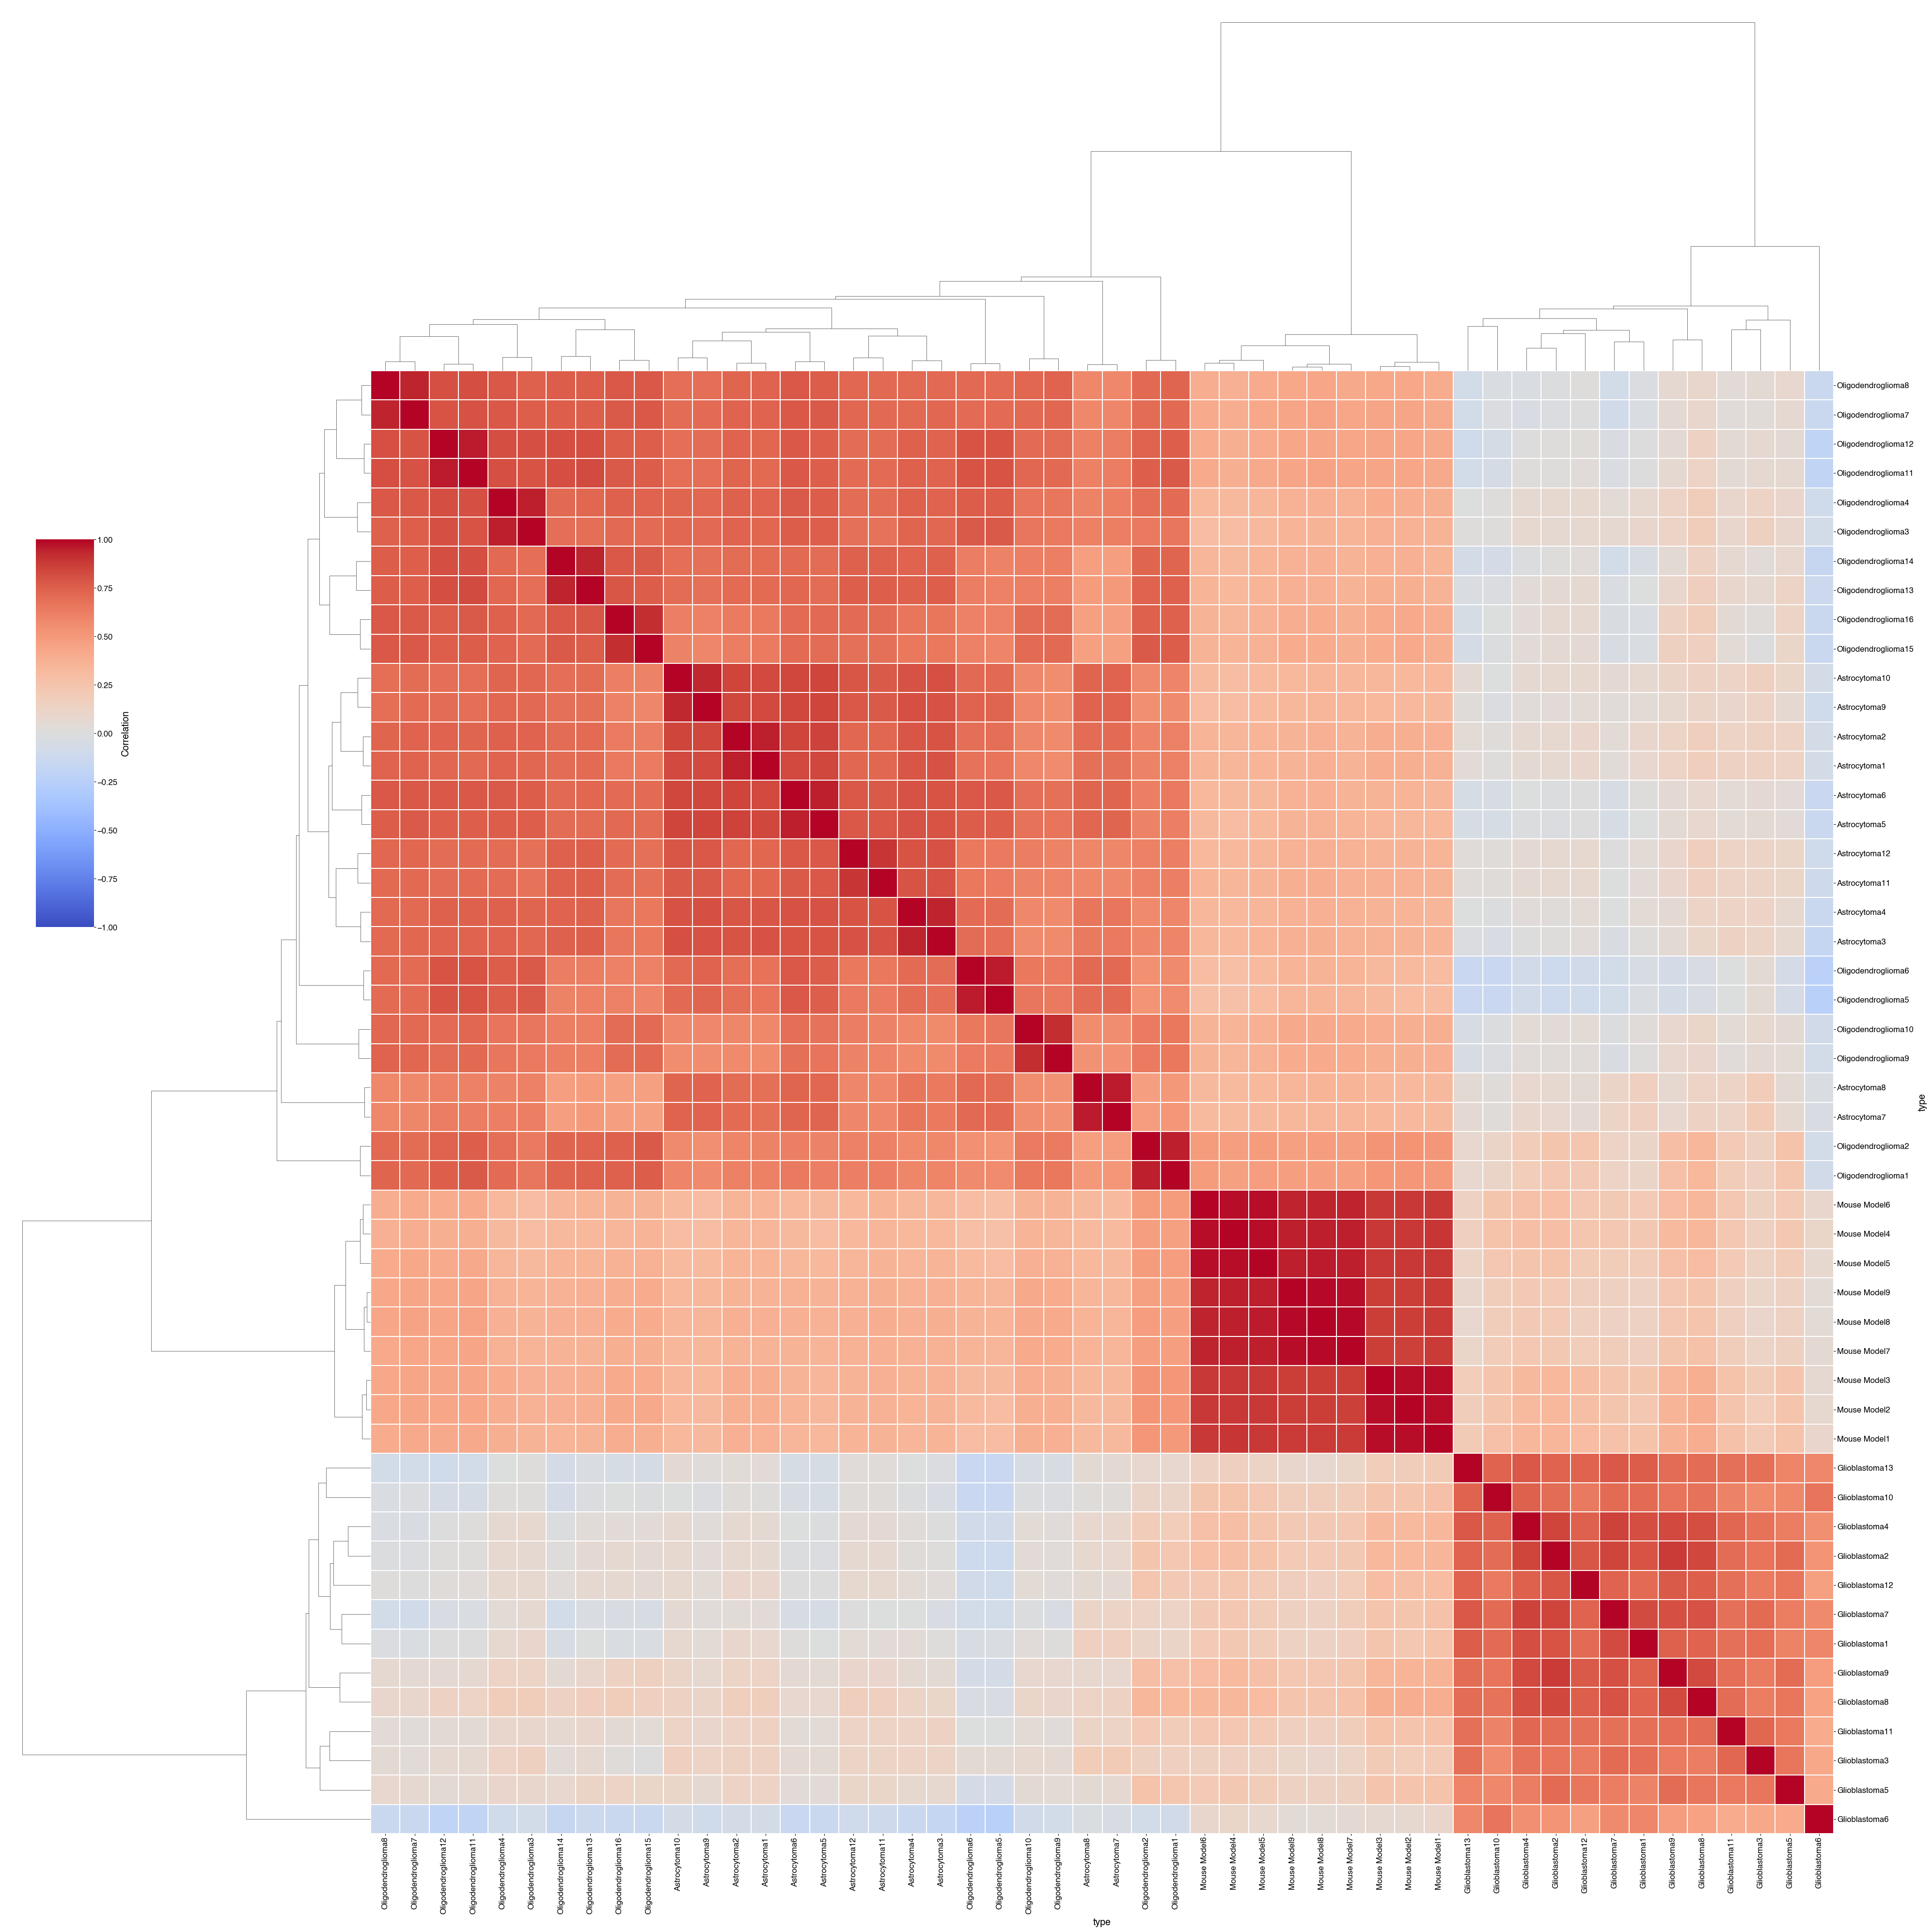

In [23]:
with mplscience.style_context():
    g = sns.clustermap(corr_mtx,
                       cmap='coolwarm', 
                       figsize=(40,40),
                       center=0,  
                       vmin=-1, vmax=1,  
                       cbar_pos=(0.02, 0.52, .03, .2),  
                       cbar_kws={'label': 'Correlation'},
                       linewidths=0.01,
                       )
    
    clustered_data = g.data2d
    flipped_data = clustered_data.T.iloc[::-1, ::-1]
    
    g.ax_heatmap.collections[0].set_array(flipped_data.values.ravel())
    
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels()[::-1])
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels()[::-1])
    
    g.ax_row_dendrogram.invert_yaxis()
    g.ax_col_dendrogram.invert_xaxis()
    
    plt.savefig(os.path.join(plot_path, 'Extended_Figure_16.pdf'), dpi=300, bbox_inches='tight')
    plt.show()